## Analysis of holtankoljak.hu station and gas price data

In [23]:
import sys 
sys.path.append('../../')

from src.import_packages import *
from src.visualize_EDA import vEDA

from ast import literal_eval
import re

import stylecloud
from IPython.display import Image, display

import statsmodels.api as sm

In [2]:
data = pd.read_csv('data/scraped_data.csv')
data.head(3)

,link,address,geo_location,services,open_hours,prices
0,https://holtankoljak.hu/omv_cece_vasutu2,"Cece, Vasút u. 2.","46.77132797,18.62500381","['kávé', ' bankkártya elfogadás', ' WC', ' ker...","['Hétfő:06:00 - 20:00', 'Kedd:06:00 - 20:00', ...","{'Gázolaj': 'Nem ismert', 'Prémium Gázolaj': '..."
1,https://holtankoljak.hu/mol_pecs_versenyutca1,"Pécs, Verseny utca 1.","46.06662369,18.23132706","['autópálya-matrica', ' mobiltelefon egyenlegf...","['Hétfő:06:00 - 22:00', 'Kedd:06:00 - 22:00', ...","{'Lpg': '325.9,- Ft', 'Cng': '435.0,- Ft /kg20..."
2,https://holtankoljak.hu/mol_kecskemet_kiskunfe...,"Kecskemét, Kiskunfélegyházi út (Szegedi út)","46.88214874,19.70771980","['HU-GO feltöltés', ' kenőolaj', ' UTA-kártya'...","['Hétfő:06:00 - 22:00', 'Kedd:06:00 - 22:00', ...","{'95-ös Benzin E10': '479.9,- Ft', 'Prémium Gá..."


### Clean up features

In [3]:
### GEO COORDS

data[['LAT', 'LON']] = data['geo_location'].str.split(',', expand = True).astype(float)
data.drop('geo_location', 1, inplace = True)

In [4]:
### PRICES

gas_types = pd.json_normalize(data['prices'].apply(eval))
gas_types.replace({'Nem ismert' : np.nan}, inplace = True)

NaN_count = gas_types.isnull().sum() / gas_types.shape[0]
keep_cols = NaN_count[NaN_count <= .75]
print('Keeping the following gas types:', keep_cols.index.tolist())

gas_types = gas_types[keep_cols.index.tolist()]

for i in gas_types.columns:
    gas_types[i] = gas_types[i].str.replace(',- Ft', '').astype(float)

data = pd.concat([data, gas_types], 1).drop(['prices'], 1)
data['Num_of_Gas_Types'] = 5 - gas_types.isnull().sum(axis=1)

Keeping the following gas types: ['Gázolaj', 'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5']


In [5]:
### OPEN HOURS

hours = data['open_hours'].apply(eval).apply(pd.Series)
hours.columns = ['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']

for i in hours.columns:

    hours[i] = hours[i]\
                    .str.replace('Hétfő:', '')\
                    .str.replace('Kedd:', '')\
                    .str.replace('Szerda:', '')\
                    .str.replace('Csütörtök:', '')\
                    .str.replace('Péntek:', '')\
                    .str.replace('Szombat:', '')\
                    .str.replace('Vasárnap:', '')\
                    .str.replace('0-24 óráig', '00:00 - 24:00')\
                    .str.replace('00:00 - 23:59', '00:00 - 24:00')\
                    .str.replace('00:00 - 00:00', '00:00 - 24:00')\
                    .str.replace('Zárva', '00:00 - 00:00')\
                    .str.replace('06:00 - 02:00', '06:00 - 26:00')\
                    .str.replace('06:00 - 00:00', '06:00 - 24:00')

def calc_hours_open(_time):
    
    OPEN = _time.split(' - ')[0]
    OPEN_CONV = int(OPEN.split(':')[0]) + int(OPEN.split(':')[1]) / 60

    CLOSE = _time.split(' - ')[1]
    CLOSE_CONV = int(CLOSE.split(':')[0]) + int(CLOSE.split(':')[1]) / 60

    HOURS_OPEN = CLOSE_CONV - OPEN_CONV

    return HOURS_OPEN

for i in hours.columns:
    hours[i] = hours[i].apply(lambda x: calc_hours_open(x))

data = pd.concat([data, hours], 1).drop(['open_hours'], 1)
data = data[data['Hétfő'] != 0]

In [6]:
data['Open_7-24'] = 0
data.loc[data[hours.columns].eq(24).all(1), 'Open_7-24'] = 1

In [7]:
### LINK

brands = pd.DataFrame(data['link'].str.replace('https://holtankoljak.hu/', '').str.split('_', expand = True)[0])

brand_mapper = {'mobil' : 'mobil-petrol', 'mol-partner' : 'mol', 'oil' : 'oil!'}
brands[0].replace(brand_mapper, inplace = True)

brand_keep = brands[0].value_counts().head(10).index.tolist()
brands.loc[~brands[0].isin(brand_keep), 0] = 'magan'
brands.columns = ['brand']

data = pd.concat([data, brands], 1)

In [8]:
### BUDAPEST or NOT

data['Budapest'] = 0
data.loc[data['link'].str.contains('budap'), 'Budapest'] = 1
#data.drop('link', 1, inplace = True)

In [9]:
### AUTOPALYA or not

data['Highway'] = 0
data.loc[(data['address'].str.lower().str.contains('km')) | 
          (data['address'].str.lower().str.contains('autópálya')) | 
          (data['address'].str.lower().str.contains('m1|m2|m2|m4|m5|m6|m7')), 'Highway'] = 1
#data.drop('address', 1, inplace = True)

In [10]:
### SERVICES

data['Num_of_Services'] = data['services'].apply(eval).apply(lambda x: len(set(x)))
all_services = data['services'].apply(eval).apply(lambda x: [i.strip() for i in x if i != '']).tolist()

all_services_flat = [item for sublist in all_services for item in sublist]
all_services_set = list(set(all_services_flat))

print('Number of total unique services available:', len(all_services_set))

Number of total unique services available: 48


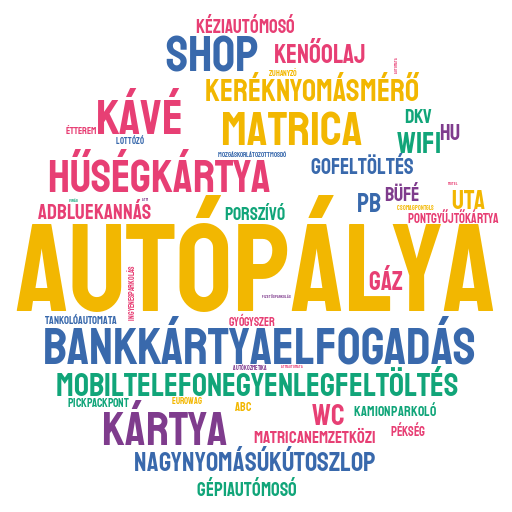

In [10]:
wc_data = ' '.join([i.replace(' ', '') for i in all_services_flat])

stylecloud.gen_stylecloud(wc_data, max_words = 750, max_font_size = 350, icon_name = 'fas fa-circle',
                          output_name = 'data/services.png', collocations = False)

display(Image(filename = 'data/services.png', width = 450))

## Distributions

In [12]:
v = vEDA(data)
print(v)

EDA visualizations for given Pandas DataFrame


In [13]:
v.plot_geo_map('LAT', 'LON', zoom = 6, color_by='brand')

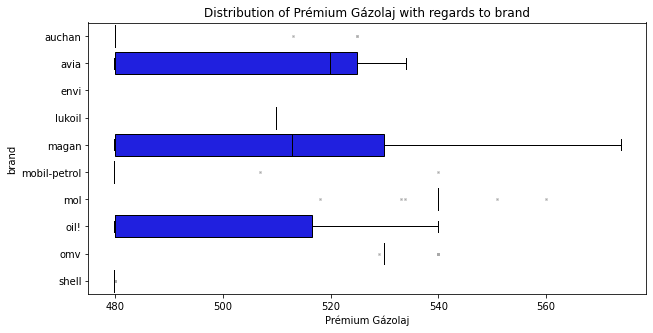

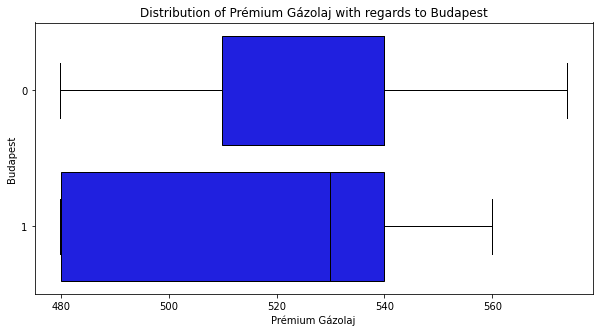

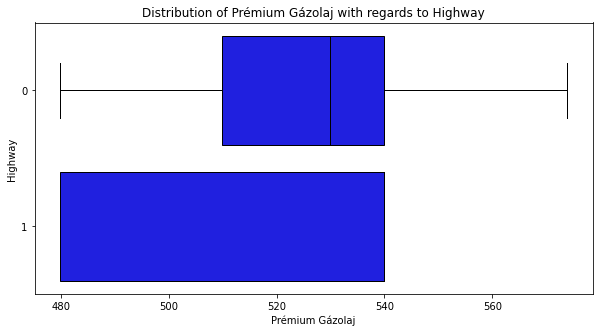

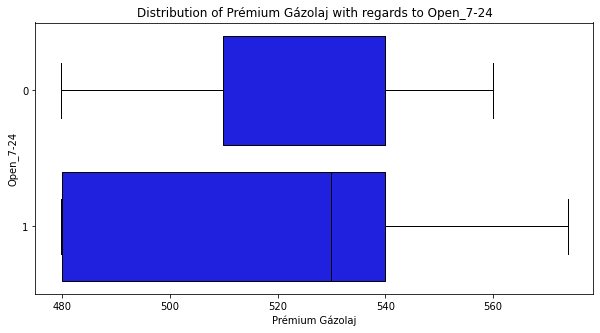

In [14]:
for i in ['brand', 'Budapest', 'Highway', 'Open_7-24']:
            v.plot_boxplot('Prémium Gázolaj', i)

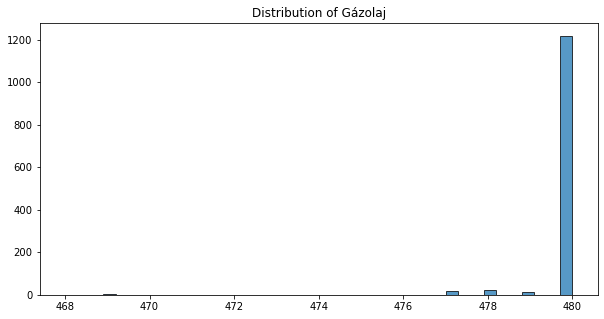

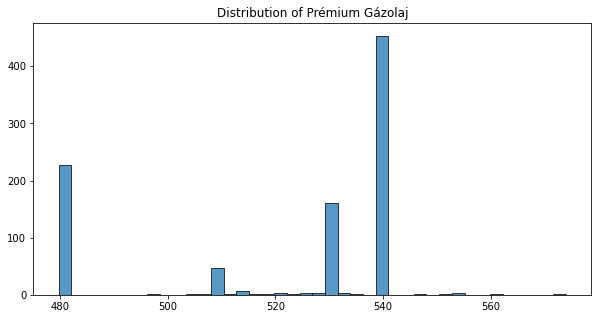

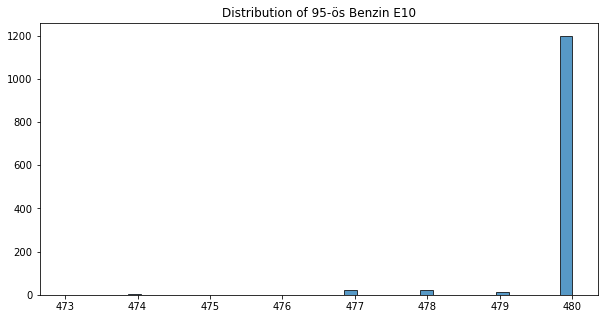

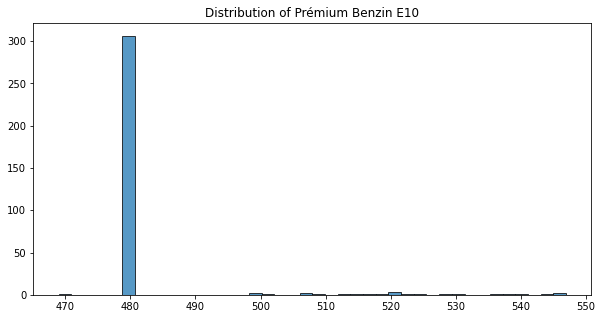

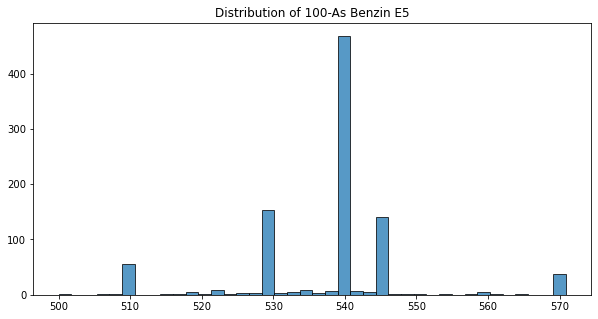

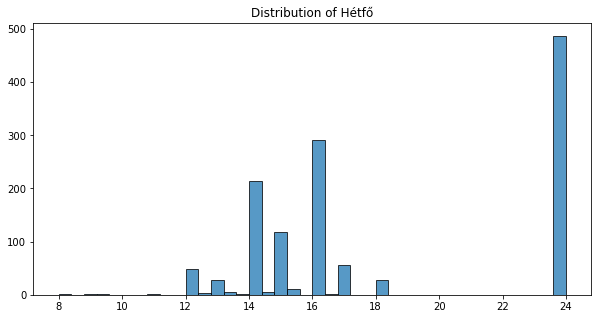

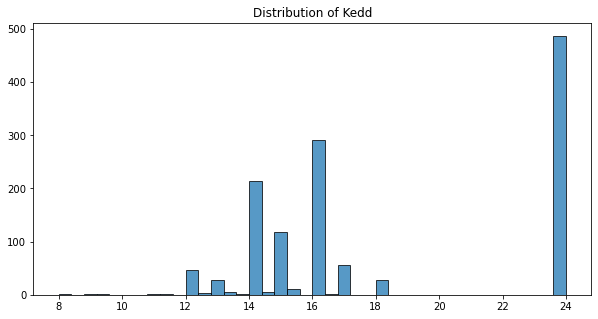

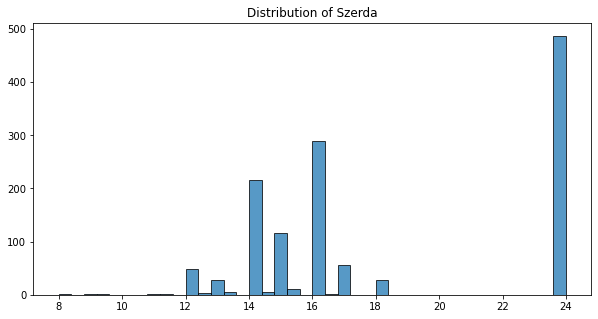

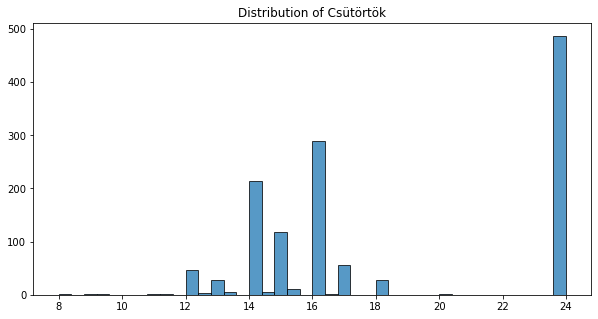

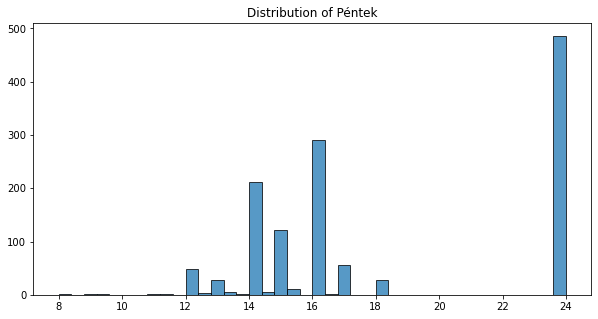

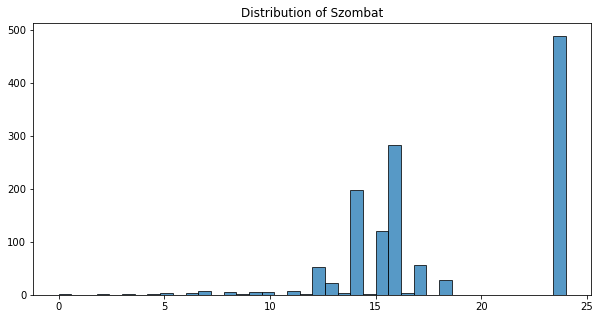

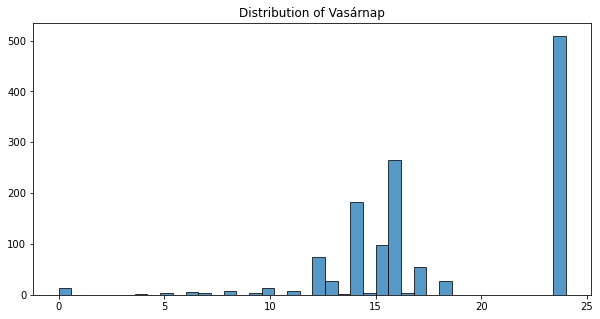

In [15]:
for i in ['Gázolaj', 'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5', 
            'Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']:
       v.plot_dist(i)

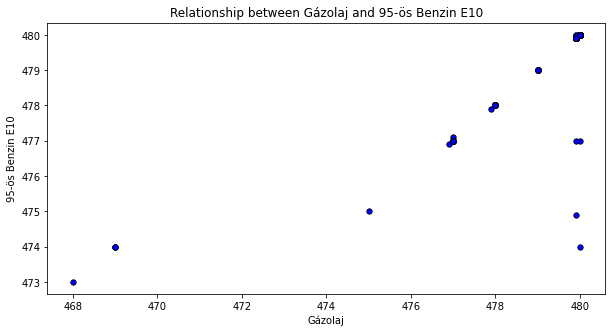

In [16]:
v.plot_scatter('Gázolaj', '95-ös Benzin E10')

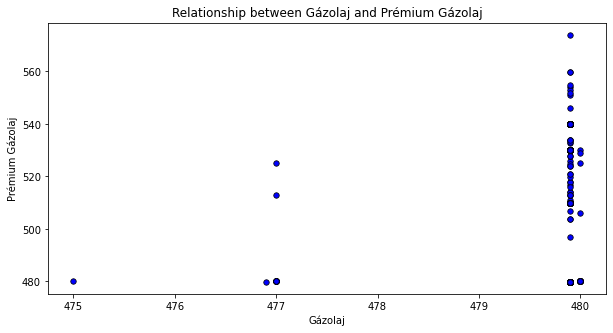

In [17]:
v.plot_scatter('Gázolaj', 'Prémium Gázolaj')

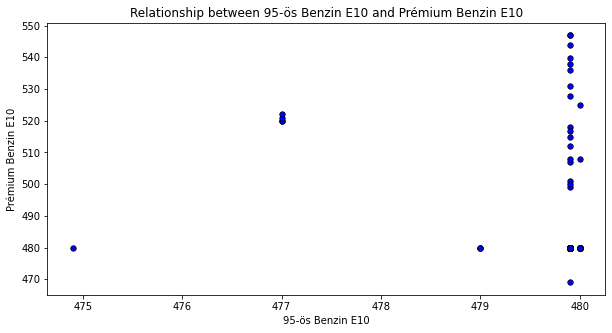

In [18]:
v.plot_scatter('95-ös Benzin E10', 'Prémium Benzin E10')

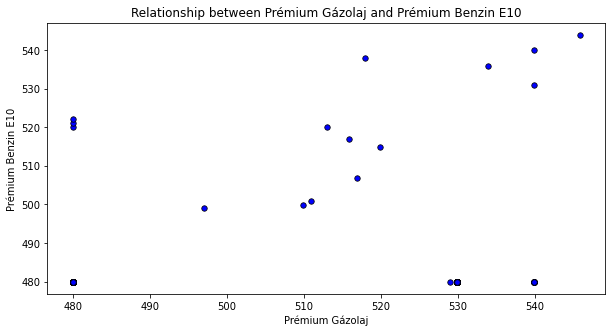

In [19]:
v.plot_scatter('Prémium Gázolaj', 'Prémium Benzin E10')

### Correlation

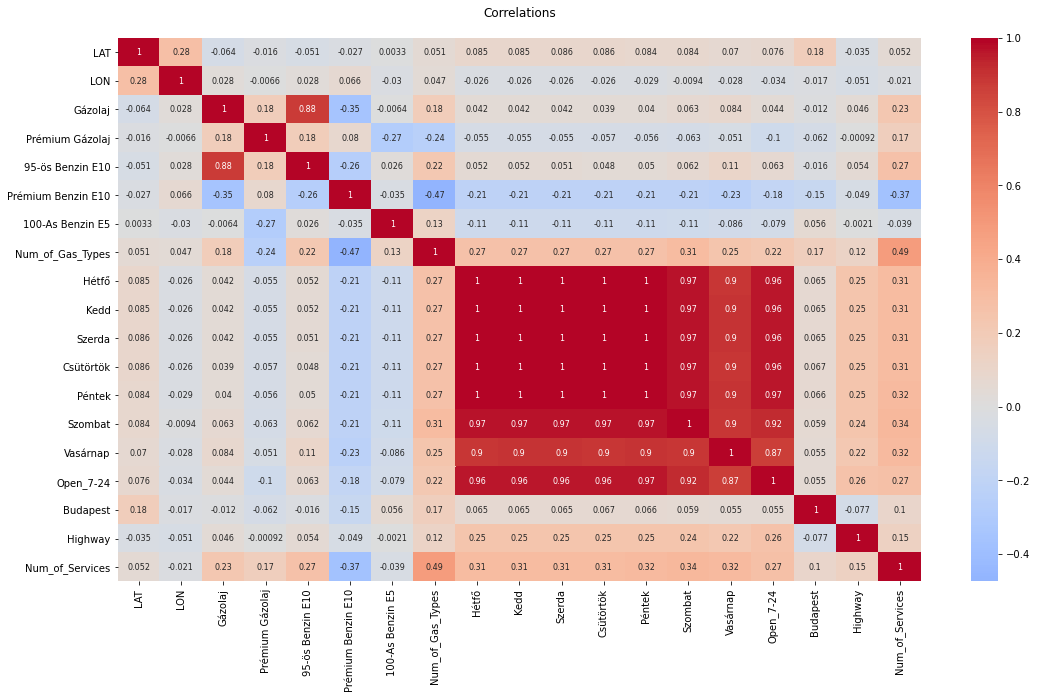

In [21]:
v.plot_corr()

## Modeling GasolPremium Diesel prices with simple OLS

### Baseline model without services, other fuel types, geo data

In [22]:
abt = data.copy()
abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'services', 'LAT', 'LON',
            'Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5'], 1, inplace = True) 
abt = abt[abt['Prémium Gázolaj'].notnull()]

abt_dummified = pd.get_dummies(abt, columns=['brand'], prefix_sep=' = ').drop(['brand = magan'], 1)
abt_dummified.dropna(inplace = True)

In [24]:
X = abt_dummified.drop(['Prémium Gázolaj'], 1)
X = sm.add_constant(X)
y = abt_dummified['Prémium Gázolaj']

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= 0.05]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [25]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Prémium Gázolaj   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     1229.
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:22:28   Log-Likelihood:                -3164.4
No. Observations:                 929   AIC:                             6347.
Df Residuals:                     920   BIC:                             6390.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  513.9816      1.269    405.160      0.000     511.492     516.471
Highway                  1.7728      0.844      2.100      0.036       0.116       3.429
Num_of_Services         -0.2766      0.079     -3.506      0.000      -0.431      -0.122
brand = auchan         -24.2879      2.123    -11.440      0.000     -28.455     -20.121
brand = mobil-petrol   -28.8921      1.380    -20.934      0.000     -31.601     -26.183
brand = mol             29.6138      0.836     35.413      0.000      27.973      31.255
brand = oil!           -11.9683      2.439     -4.907      0.000     -16.755      -7.181
brand = omv             21.3353      1.006     21.217      0.000      19.362      23.309
brand = shell          -30.5008      0.961    -31.748      0.000     -32.386     -28.615
==============================================================================
Omnibus:                      578.004   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23525.884
Skew:                           2.216   Prob(JB):                         0.00
Kurtosis:                      27.251   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Adding all services as dummies

In [26]:
abt = data.copy()
abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'LAT', 'LON',
            'Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5'], 1, inplace = True) 
abt = abt[abt['Prémium Gázolaj'].notnull()]

abt_dummified = pd.get_dummies(abt, columns=['brand'], prefix_sep=' = ').drop(['brand = magan'], 1)
abt_dummified.dropna(inplace = True)

In [27]:
services_dummified = abt_dummified.services.apply(eval).apply(lambda x: list(set(x))).apply(lambda x: [ i.strip() for i in x if i != '']).str.join('|').str.get_dummies()
services_dummified.loc[services_dummified['ATM automata'] != services_dummified['ATM-automata'], 'ATM automata'] = services_dummified.loc[services_dummified['ATM automata'] != services_dummified['ATM-automata'], 'ATM-automata']
services_dummified.drop(['ATM-automata'], 1, inplace = True)

In [28]:
abt_dummified = pd.concat([abt_dummified, services_dummified], 1).drop('services', 1)

In [29]:
X = abt_dummified.drop(['Prémium Gázolaj'], 1)
X = sm.add_constant(X)
y = abt_dummified['Prémium Gázolaj']

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= 0.05]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [30]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Prémium Gázolaj   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     602.6
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:23:25   Log-Likelihood:                -3094.1
No. Observations:                 929   AIC:                             6228.
Df Residuals:                     909   BIC:                             6325.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  518.0352      1.538    336.904      0.000     515.017     521.053
Num_of_Services         -0.4426      0.096     -4.605      0.000      -0.631      -0.254
brand = auchan         -34.5094      2.644    -13.052      0.000     -39.698     -29.321
brand = lukoil          -7.2769      1.668     -4.364      0.000     -10.550      -4.004
brand = mobil-petrol   -34.3937      1.545    -22.259      0.000     -37.426     -31.361
brand = mol             22.4823      1.311     17.154      0.000      19.910      25.054
brand = oil!           -13.2915      2.426     -5.479      0.000     -18.052      -8.531
brand = omv             14.9225      1.398     10.675      0.000      12.179      17.666
brand = shell          -38.0668      1.411    -26.970      0.000     -40.837     -35.297
Eurowag-kártya          -7.7326      1.922     -4.022      0.000     -11.505      -3.960
Fizetős parkolás       -35.1384      5.168     -6.799      0.000     -45.282     -24.995
Ingyenes töltés        -23.2842      7.132     -3.265      0.001     -37.282      -9.286
Pick Pack Pont           2.0574      0.773      2.660      0.008       0.540       3.575
Wifi                     2.1161      0.653      3.240      0.001       0.834       3.398
autókozmetika            9.4976      2.559      3.712      0.000       4.476      14.519
hűségkártya              3.5592      0.828      4.301      0.000       1.935       5.183
kamion parkoló           1.8337      0.759      2.417      0.016       0.344       3.323
motel                  -25.8980      7.117     -3.639      0.000     -39.866     -11.930
tankoló automata         3.5050      1.572      2.230      0.026       0.420       6.590
virág                   13.1288      3.895      3.371      0.001       5.485      20.773
==============================================================================
Omnibus:                      477.780   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17854.514
Skew:                           1.679   Prob(JB):                         0.00
Kurtosis:                      24.213   Cond. No.                         487.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion: 
- adding service indicators increased adj R2 from 91.4 to 92.5
- most influence: **BRAND**, **number of services**, **couple of services (flowers, motel, free charging, paid parking)**